In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import os
import itertools


In [ ]:
import kagglehub
dataset = kagglehub.dataset_download("vitaminc/cigarette-smoker-detection")
print("Path to dataset files:", dataset)

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, walk_through_dir

dataset = "/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1"
walk_through_dir(dataset)


100%|██████████| 2.50G/2.50G [01:35<00:00, 28.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1
--2024-12-20 20:14:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-20 20:14:52 (58.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]

There are 1 directories and 0 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1'.
There are 3 directories and 1 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1/data'.
There are 0 directories an

Number of images found: 6496
Number of classes: 2
                                            Filepath    Label
0  /root/.cache/kagglehub/datasets/vitaminc/cigar...  smoking
1  /root/.cache/kagglehub/datasets/vitaminc/cigar...  smoking
2  /root/.cache/kagglehub/datasets/vitaminc/cigar...  smoking
3  /root/.cache/kagglehub/datasets/vitaminc/cigar...  smoking
4  /root/.cache/kagglehub/datasets/vitaminc/cigar...  smoking


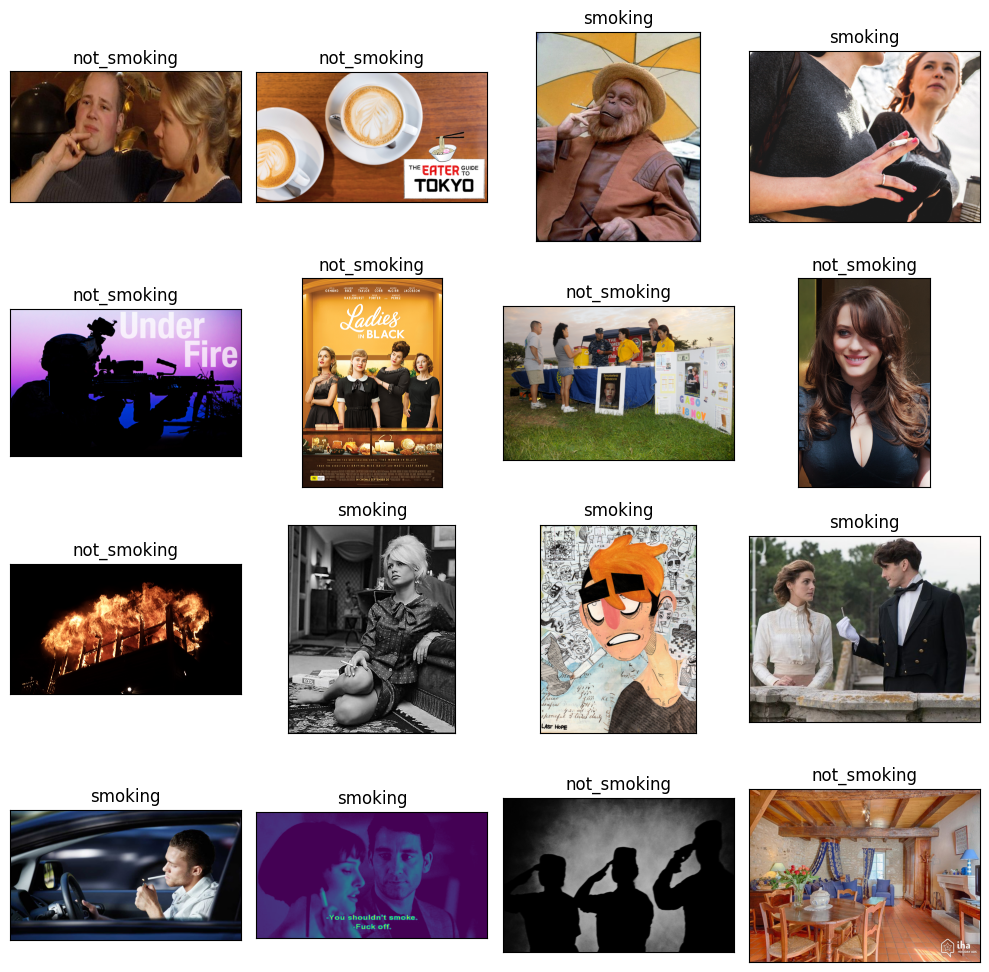

In [ ]:
# تجهيز مسارات الصور والتسميات
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# تعريف مسار مجموعة البيانات
image_dir = Path("/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1")

# البحث عن الصور في كل المجلدات (JPG, JPEG, PNG)
filepaths = list(image_dir.rglob('*.JPG')) + list(image_dir.rglob('*.jpg')) + \
            list(image_dir.rglob('*.png')) + list(image_dir.rglob('*.jpeg'))

# التحقق من وجود الصور
if len(filepaths) == 0:
    raise ValueError("No image files found in the dataset directory. Please check the dataset path or file extensions.")

# استخراج التسميات من أسماء المجلدات
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# دمج المسارات مع التسميات في DataFrame
image_df = pd.concat([filepaths, labels], axis=1)

# عرض عدد الصور وعدد الفئات
print(f"Number of images found: {len(image_df)}")
print(f"Number of classes: {len(image_df['Label'].unique())}")
print(image_df.head())

# عرض عينات من الصور
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import os
import warnings

# Suppress warnings from PIL
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

# Download dataset
import kagglehub
dataset = kagglehub.dataset_download("vitaminc/cigarette-smoker-detection")
dataset_path = "/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1"

# Display dataset files to ensure correct path
print("Files in dataset folder:", os.listdir(dataset_path))

# Extract file paths and labels
image_dir = Path(dataset_path)
filepaths = list(image_dir.rglob("*.JPG")) + list(image_dir.rglob("*.jpg")) + \
            list(image_dir.rglob("*.png")) + list(image_dir.rglob("*.jpeg"))

# Verify the number of images
print(f"Number of images found: {len(filepaths)}")
if len(filepaths) == 0:
    raise ValueError("No images found. Please check the dataset path and file extensions.")

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Combine filepaths and labels into a DataFrame
image_df = pd.concat([filepaths, labels], axis=1)

# Split data into training and test sets
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, shuffle=True)

# ImageDataGenerator with augmentation
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

# Generate train, validation, and test data
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Model Definition
pretrained_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-4]:  # Keep the last 4 layers trainable
    layer.trainable = False

model = Sequential([
    pretrained_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "vgg16_smoker_classification_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True
)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Model Training
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,  # Number of epochs
    callbacks=[early_stopping, checkpoint_callback],
    verbose=1
)

# Evaluate Model
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


Files in dataset folder: ['data']
Number of images found: 6496
Found 4157 validated image filenames belonging to 2 classes.
Found 1039 validated image filenames belonging to 2 classes.
Found 1300 validated image filenames belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5484 - loss: 6.6317 - val_accuracy: 0.6593 - val_loss: 0.9055
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5811 - loss: 1.8450 - val_accuracy: 0.6516 - val_loss: 0.6848
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5817 - loss: 1.0131 - val_accuracy: 0.6785 - val_loss: 0.6252
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.5711 - loss: 0.8447 - val_accuracy: 0.6968 - val_loss: 0.6230
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.5884 - loss: 0.7595 - val_accuracy: 0.6997 - val_loss: 0.6059
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.6103 - loss: 0.7084 - val_accuracy: 0.7286 - val_loss: 0.5982
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.6223 - loss: 0.6847 - val_accuracy: 0.7064 - val_loss: 0.5932
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.6362 - loss: 0.6664 - val_accuracy: 0.725

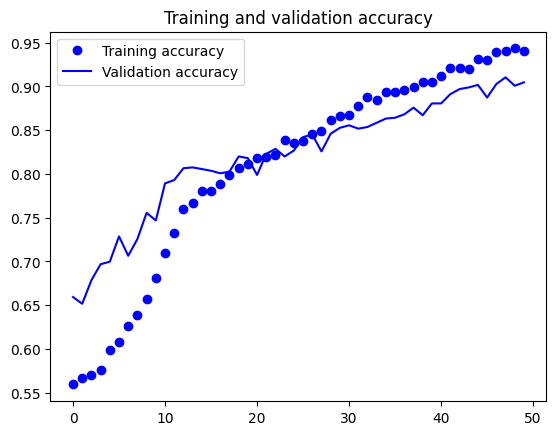

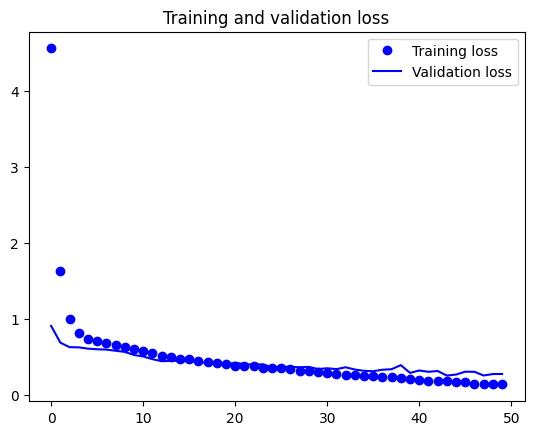

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 656ms/step
The first 5 predictions: ['smoking', 'smoking', 'not_smoking', 'smoking', 'smoking']


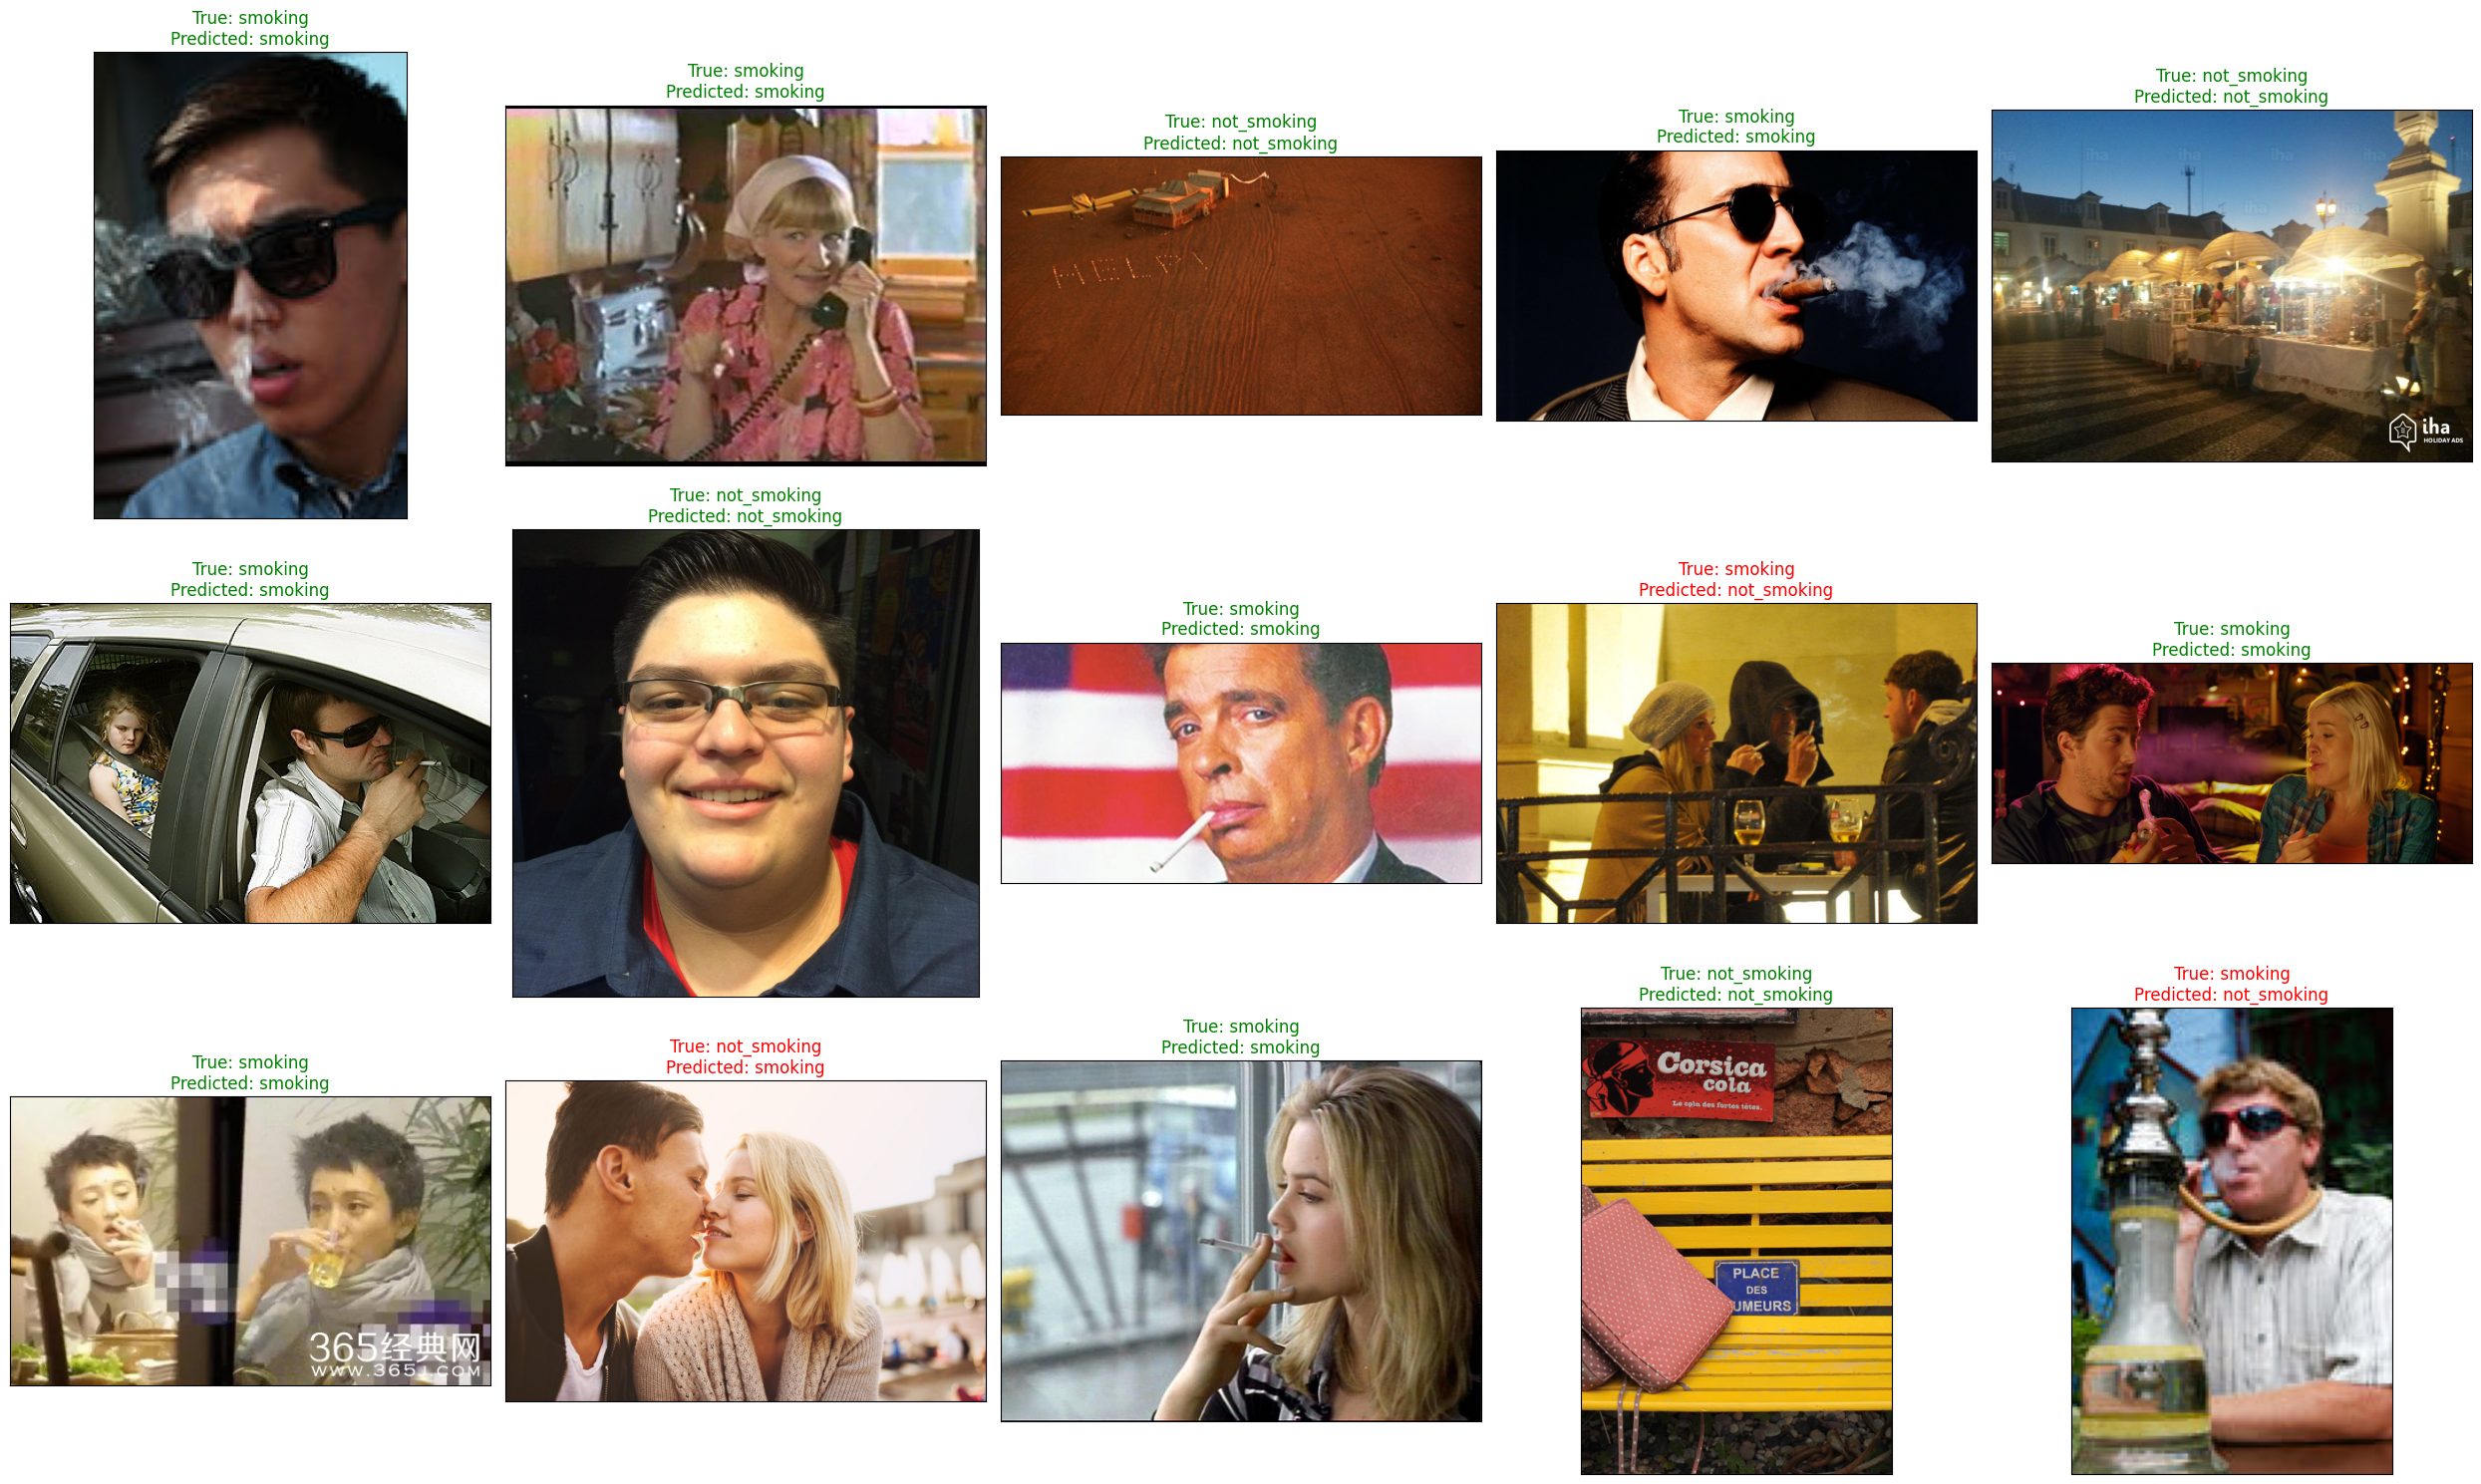

              precision    recall  f1-score   support

 not_smoking       0.87      0.86      0.86       530
     smoking       0.90      0.91      0.91       770

    accuracy                           0.89      1300
   macro avg       0.88      0.88      0.88      1300
weighted avg       0.89      0.89      0.89      1300

              precision    recall  f1-score      support
not_smoking    0.866412  0.856604  0.861480   530.000000
smoking        0.902062  0.909091  0.905563   770.000000
accuracy       0.887692  0.887692  0.887692     0.887692
macro avg      0.884237  0.882847  0.883521  1300.000000
weighted avg   0.887528  0.887692  0.887591  1300.000000


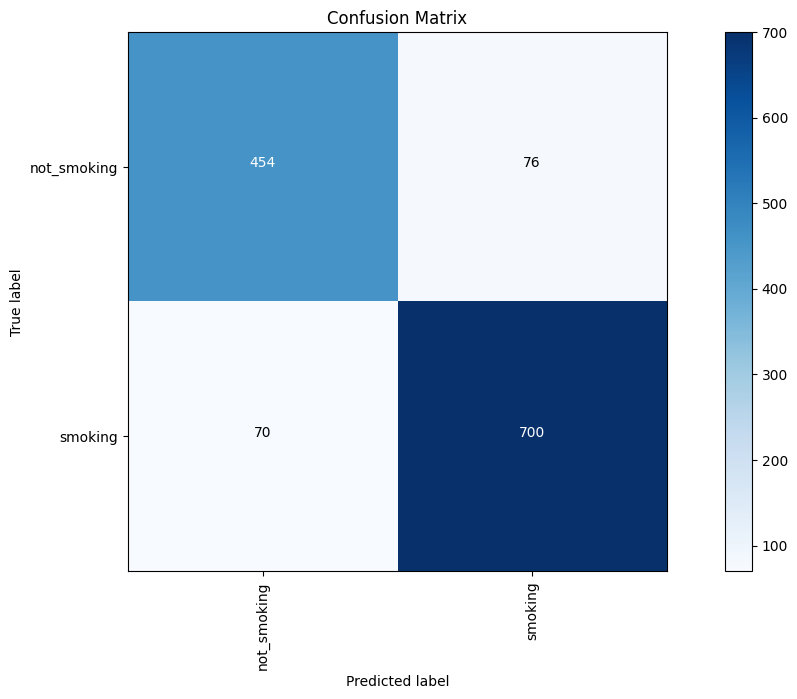

In [ ]:
# رسم دقة التدريب والتحقق
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# التنبؤ بتسميات صور الاختبار
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# خريطة التصنيفات
labels_dict = (train_images.class_indices)
labels_dict = dict((v,k) for k,v in labels_dict.items())
pred_labels = [labels_dict[k] for k in pred]

# عرض أول 5 تنبؤات
print(f'The first 5 predictions: {pred_labels[:5]}')

# عرض 25 صورة عشوائية من البيانات مع تسمياتها
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred_labels[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred_labels[random_index[i]]}", color=color)
plt.tight_layout()
plt.show()

# حساب تقرير التصنيف
y_test = list(test_df.Label)
print(classification_report(y_test, pred_labels))

report = classification_report(y_test, pred_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

# دالة رسم مصفوفة الالتباس
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix", xlabel="Predicted label", ylabel="True label", xticks=np.arange(n_classes), yticks=np.arange(n_classes), xticklabels=labels, yticklabels=labels)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)", horizontalalignment="center", color="white" if cm[i, j] > threshold else "black", size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center", color="white" if cm[i, j] > threshold else "black", size=text_size)

    if savefig:
        fig.savefig("confusion_matrix.png")

# رسم مصفوفة الالتباس
make_confusion_matrix(y_test, pred_labels, list(labels_dict.values()))
